Satria Baladewa Harahap

satriabaladewaharahap@gmail.com

In [ ]:
!wget --no-check-certificate https://github.com/Xhydracore/Belajar-Pengembangan-Machine-Learning/raw/master/Submission%202/TSLA.csv

--2022-11-22 13:26:59--  https://github.com/Xhydracore/Belajar-Pengembangan-Machine-Learning/raw/master/Submission%202/TSLA.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Xhydracore/Belajar-Pengembangan-Machine-Learning/master/Submission%202/TSLA.csv [following]
--2022-11-22 13:26:59--  https://raw.githubusercontent.com/Xhydracore/Belajar-Pengembangan-Machine-Learning/master/Submission%202/TSLA.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 175082 (171K) [text/plain]
Saving to: ‘TSLA.csv’

TSLA.csv            100%[===================>] 170.98K  --.-KB/s    in 0.009s  

2022-11-22 13:27

In [ ]:
import numpy as np
import pandas as pd
import datetime
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf

df = pd.read_csv('/content/TSLA.csv')

In [ ]:
def parse(x):
    return datetime.datetime.strptime(x, '%Y-%m-%d')

df = pd.read_csv('/content/TSLA.csv',  parse_dates = True, index_col=0, date_parser=parse)
df.columns = ['Open', 'High', 'Low', 'Close', 'Adj_close', 'Volume']
df.index.name = 'Date'

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2416 entries, 2010-06-29 to 2020-02-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2416 non-null   float64
 1   High       2416 non-null   float64
 2   Low        2416 non-null   float64
 3   Close      2416 non-null   float64
 4   Adj_close  2416 non-null   float64
 5   Volume     2416 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 132.1 KB


In [ ]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj_close    0
Volume       0
dtype: int64

In [ ]:
df

,Open,High,Low,Close,Adj_close,Volume
Date,,,,,,
2010-06-29,19.000000,25.000000,17.540001,23.889999,23.889999,18766300
2010-06-30,25.790001,30.420000,23.299999,23.830000,23.830000,17187100
2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800
2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800
2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900
...,...,...,...,...,...,...
2020-01-28,568.489990,576.809998,558.080017,566.900024,566.900024,11788500
2020-01-29,575.690002,589.799988,567.429993,580.989990,580.989990,17801500
2020-01-30,632.419983,650.880005,618.000000,640.809998,640.809998,29005700


In [ ]:
df.describe()

,Open,High,Low,Close,Adj_close,Volume
count,2416.000000,2416.000000,2416.000000,2416.000000,2416.000000,2.416000e+03
mean,186.271147,189.578224,182.916639,186.403651,186.403651,5.572722e+06
std,118.740163,120.892329,116.857591,119.136020,119.136020,4.987809e+06
min,16.139999,16.629999,14.980000,15.800000,15.800000,1.185000e+05
25%,34.342498,34.897501,33.587501,34.400002,34.400002,1.899275e+06
50%,213.035004,216.745002,208.870002,212.960007,212.960007,4.578400e+06
75%,266.450012,270.927513,262.102501,266.774994,266.774994,7.361150e+06
max,673.690002,786.140015,673.520020,780.000000,780.000000,4.706500e+07


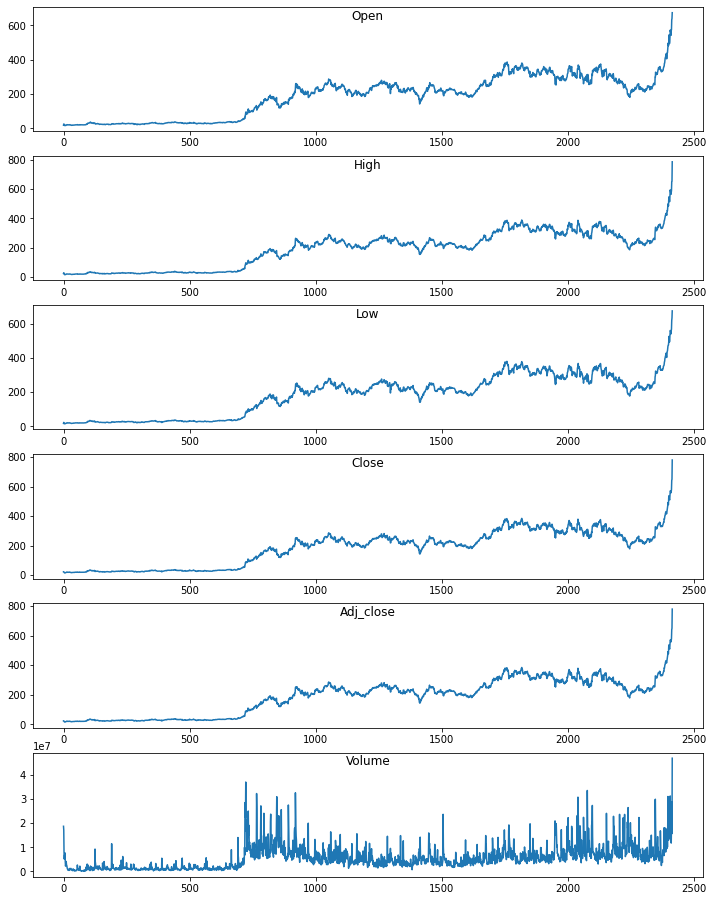

In [ ]:
values = df.values

num_f = len(df.columns)

groups = [x for x in range(num_f)]

plt.figure(figsize = (12,16))

i = 1
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.85, loc='center')
    i += 1
plt.show()

In [ ]:
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# split train set
training_set = df['Open'].values
len_train = int(len(training_set)*0.8)
data_train = training_set[:len_train]
data_val = training_set[len_train:]

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
tf.keras.backend.clear_session()

train_set = windowed_dataset(data_train, window_size=60, batch_size=100, shuffle_buffer=1000)

model = Sequential([
  Bidirectional(LSTM(60, return_sequences=True)),
  Bidirectional(LSTM(60)),
  Dense(30, activation="relu"),
  Dropout(0.7),
  Dense(10, activation="relu"),
  Dense(10, activation="relu"),
  Dense(1), 
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


19/19 [==============================] - 12s 36ms/step - loss: 159.3410 - mae: 159.8405 - lr: 1.0000e-08
Epoch 2/100
19/19 [==============================] - 1s 22ms/step - loss: 160.6362 - mae: 161.1353 - lr: 1.1220e-08
Epoch 3/100
19/19 [==============================] - 1s 23ms/step - loss: 158.2392 - mae: 158.7377 - lr: 1.2589e-08
Epoch 4/100
19/19 [==============================] - 1s 22ms/step - loss: 155.0497 - mae: 155.5486 - lr: 1.4125e-08
Epoch 5/100
19/19 [==============================] - 1s 22ms/step - loss: 154.2181 - mae: 154.7176 - lr: 1.5849e-08
Epoch 6/100
19/19 [==============================] - 1s 22ms/step - loss: 153.7992 - mae: 154.2986 - lr: 1.7783e-08
Epoch 7/100
19/19 [==============================] - 1s 21ms/step - loss: 153.2300 - mae: 153.7286 - lr: 1.9953e-08
Epoch 8/100
19/19 [==============================] - 1s 23ms/step - loss: 153.5022 - mae: 154.0012 - lr: 2.2387e-08
Epoch 9/100
19/19 [==============================] - 1s 21ms/step - loss: 153.0073 

(1e-08, 0.001, 0.0, 300.0)

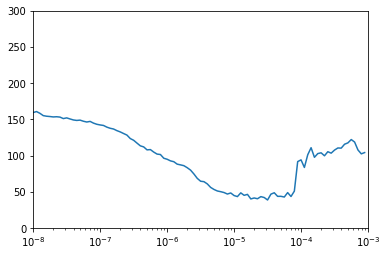

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<10):
      print("\nMAE of the model <10% of data scale")
      self.model.stop_training = True
callbacks = myCallback()


In [ ]:
minMae = (df['Open'].max() - df['Open'].min()) * 10/100
minMae

65.7550003

In [ ]:
tf.keras.backend.clear_session()

train_set = windowed_dataset(data_train, window_size=60, batch_size=200, shuffle_buffer=1000)

model = Sequential([
  Bidirectional(LSTM(60, return_sequences=True)),
  Bidirectional(LSTM(60)),
  Dense(30, activation="relu"),
  Dropout(0.7),
  Dense(10, activation="relu"),
  Dense(10, activation="relu"),
  Dense(1), 
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=500, callbacks=[callbacks])

Epoch 1/500
10/10 [==============================] - 7s 31ms/step - loss: 128.8107 - mae: 129.3095
Epoch 2/500
10/10 [==============================] - 0s 28ms/step - loss: 101.8920 - mae: 102.3905
Epoch 3/500
10/10 [==============================] - 0s 27ms/step - loss: 88.1684 - mae: 88.6678
Epoch 4/500
10/10 [==============================] - 0s 29ms/step - loss: 76.3403 - mae: 76.8391
Epoch 5/500
10/10 [==============================] - 0s 27ms/step - loss: 71.0423 - mae: 71.5409
Epoch 6/500
10/10 [==============================] - 0s 28ms/step - loss: 63.0849 - mae: 63.5841
Epoch 7/500
10/10 [==============================] - 0s 27ms/step - loss: 58.2844 - mae: 58.7837
Epoch 8/500
10/10 [==============================] - 0s 28ms/step - loss: 55.7558 - mae: 56.2550
Epoch 9/500
10/10 [==============================] - 0s 31ms/step - loss: 51.6726 - mae: 52.1703
Epoch 10/500
10/10 [==============================] - 0s 31ms/step - loss: 49.9827 - mae: 50.4804
Epoch 11/500
10/10 [=====

<Figure size 432x288 with 0 Axes>

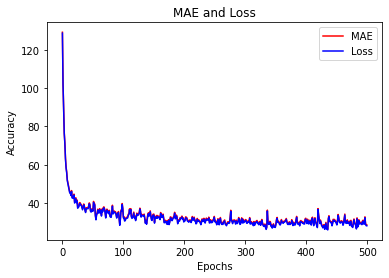

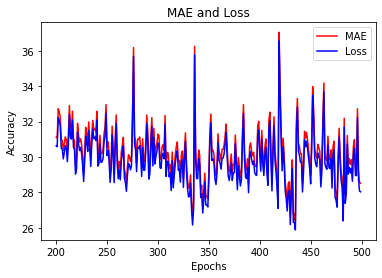

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

# Plot MAE and Loss
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss))

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

# Plot Zoomed MAE and Loss
epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()